# Training all BDTs for the WVZ Analysis

In [52]:
from wvz_helpers import load_dataframes, load_dataframe, skims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import os

In [2]:
from train_bdt import zz_features, ttz_features, xgb_params_emu, xgb_params_offz
import xgboost as xgb

## Helper Function

In [3]:
def get_scale_pos_weight(y_train, w_train):
    n_pos = np.sum(y_train)
    n_neg = len(y_train) - n_pos
    print("n_pos: " + str(n_pos))
    print("n_neg: " + str(n_neg))
    n_pos_w = np.sum(w_train[y_train == True])
    n_neg_w = np.sum(w_train[y_train == False])
    print("n_pos (weighted): " + str(n_pos_w))
    print("n_neg (weighted): " + str(n_neg_w))
    scale_pos_weight = 1.0 * n_neg_w / n_pos_w
    print(f"scale_pos_weight: {scale_pos_weight}")
    return scale_pos_weight

In [48]:
def plot_bdt_scores(df, score_column, samples, bins = np.linspace(-10, 10, 51), weight_column="weight"):
    df_train = df.query(train_query)
    df_test = df.query(test_query)
    
    for do_train, df_check in [(True, df_train), (False, df_test)]:
        plt.gca().set_prop_cycle(None)
        for sample in samples:
            df_sel = df_check.query(f"sample == '{sample}'")

            plt.hist(df_sel[score_column],
                     bins,
                     weights=df_sel[weight_column] * (3 / (1 + do_train)),
                     histtype="step",
                     label=sample + (" (train)" if do_train else " (test)"),
                     linestyle='--' if do_train else '-',
            )
    plt.legend(ncol=2)

In [53]:
def save_model(model, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    model.save_model(os.path.join(path, name + ".bin"))
    model.get_booster().dump_model(os.path.join(path, name + ".txt"))

In [57]:
def get_training_weights(df):
    training_weights = df.groupby("sample")["weight"].sum() / df["sample"].value_counts()
    training_weights = training_weights / training_weights.sum()
    return training_weights[df["sample"]].values

In [59]:
def get_targets(df):
    y_tests = {
        "nonh_wwz" : df_test.eval("sample == 'nonh_wwz'"),
        "wwz" : df_test.eval("sample == 'nonh_wwz' or sample == 'zh_wwz'"),
    }
    y_trains = {
        "nonh_wwz" : df_train.eval("sample == 'nonh_wwz'"),
        "wwz" : df_train.eval("sample == 'nonh_wwz' or sample == 'zh_wwz'"),
    }
    return y_tests, y_trains

## General Configuration

In [56]:
train_query = "evt % 3 != 0"
test_query = "evt % 3 == 0"

## Training the ZZ BDT in the EMu region

In [4]:
df = load_dataframes(["nonh_wwz", "zh_wwz", "zz"], concat=True, entrystop=None)
df = df.query("is_ChannelEMu")
df["training_weight"] = get_training_weights(df)

In [9]:
df_train = df.query(train_query)
df_test = df.query(test_query)

X_train = df_train[zz_features]
X_test = df_test[zz_features]

w_train = df_train["training_weight"]
w_test = df_test["training_weight"]

y_tests, y_trains = get_targets(df)

In [25]:
models = {}

for signal_definition, y_train in y_trains.items():
    print("Fitting BDT for " + signal_definition + " as signal...")
    models[signal_definition] = xgb.XGBClassifier(
        scale_pos_weight=get_scale_pos_weight(y_train, w_train),
        verbosity=0,
        n_jobs=4,
        random_state=30,
        objective="binary:logitraw",
        **xgb_params_emu,
    )
    models[signal_definition].fit(X_train, y_train, sample_weight=w_train)

save_model(models["wwz"], "models/wwz", "emu_zz")
save_model(models["nonh_wwz"], "models/nonh_wwz","emu_zz")

In [29]:
df["EMu_zz_score_wwz"] = models["wwz"].predict_proba(df[zz_features])[:,1]
df["EMu_zz_score_nonh_wwz"] = models["nonh_wwz"].predict_proba(df[zz_features])[:,1]

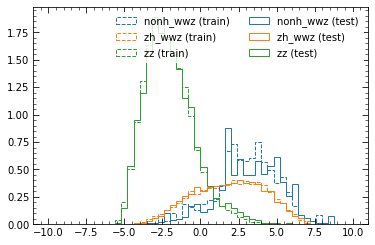

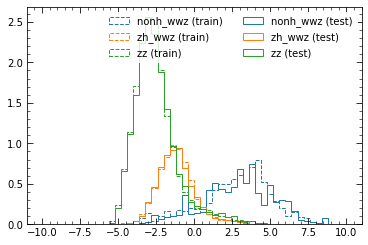

In [50]:
plot_bdt_scores(df, "EMu_zz_score_wwz", ["nonh_wwz", "zh_wwz", "zz"])
plt.show()
plot_bdt_scores(df, "EMu_zz_score_nonh_wwz", ["nonh_wwz", "zh_wwz", "zz"])
plt.show()

## Training the ZZ BDT in the OffZ region

In [61]:
df = load_dataframes(["nonh_wwz", "zh_wwz", "zz"], concat=True, entrystop=None)
df = df.query("is_ChannelOffZ")
df["training_weight"] = get_training_weights(df)

In [62]:
df_train = df.query(train_query)
df_test = df.query(test_query)

X_train = df_train[zz_features]
X_test = df_test[zz_features]

w_train = df_train["training_weight"]
w_test = df_test["training_weight"]

y_tests, y_trains = get_targets(df)

In [64]:
# This training takes quite some time

models = {}

for signal_definition, y_train in y_trains.items():
    print("Fitting BDT for " + signal_definition + " as signal...")
    models[signal_definition] = xgb.XGBClassifier(
        scale_pos_weight=get_scale_pos_weight(y_train, w_train),
        verbosity=0,
        n_jobs=4,
        random_state=30,
        objective="binary:logitraw",
        **xgb_params_offz,
    )
    models[signal_definition].fit(X_train, y_train, sample_weight=w_train)

save_model(models["wwz"], "models/wwz", "offz_zz")
save_model(models["nonh_wwz"], "models/nonh_wwz","offz_zz")

Fitting BDT for nonh_wwz as signal...
n_pos: 223342
n_neg: 869214
n_pos (weighted): 9039.392041612198
n_neg (weighted): 678512.963221321
scale_pos_weight: 75.06179177734906
Fitting BDT for wwz as signal...
n_pos: 279375
n_neg: 813181
n_pos (weighted): 16569.872863568213
n_neg (weighted): 670982.482399365
scale_pos_weight: 40.49412375846518


In [65]:
df["OffZ_zz_score_wwz"] = models["wwz"].predict_proba(df[zz_features])[:,1]
df["OffZ_zz_score_nonh_wwz"] = models["nonh_wwz"].predict_proba(df[zz_features])[:,1]

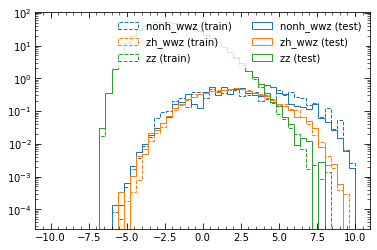

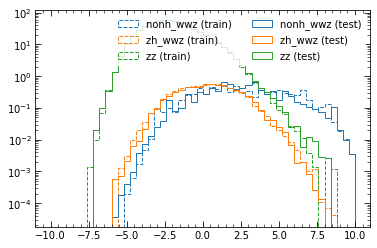

In [67]:
plot_bdt_scores(df, "OffZ_zz_score_wwz", ["nonh_wwz", "zh_wwz", "zz"])
plt.yscale('log', nonposy='clip')
plt.show()
plot_bdt_scores(df, "OffZ_zz_score_nonh_wwz", ["nonh_wwz", "zh_wwz", "zz"])
plt.yscale('log', nonposy='clip')
plt.show()

## Training the ZZ BDT in the EMu region

In [68]:
df = load_dataframes(["nonh_wwz", "zh_wwz", "ttz"], concat=True, entrystop=None)
df = df.query("is_ChannelEMu or is_ChannelBTagEMu")
df["training_weight"] = get_training_weights(df)

In [75]:
models = {}

for signal_definition in ["wwz", "nonh_wwz"]:
    
    if signal_definition == "wwz":
        df_train = df.query(train_query)
        X_train = df_train[ttz_features]
        w_train = df_train["training_weight"]
        y_train = df_train.eval("sample == 'nonh_wwz' or sample == 'zh_wwz'")
    if signal_definition == "nonh_wwz":
        df_train = df.query(train_query).query("sample != 'zh_wwz'")
        X_train = df_train[ttz_features]
        w_train = df_train["training_weight"]
        y_train = df_train.eval("sample == 'nonh_wwz'")
    
    print("Fitting BDT for " + signal_definition + " as signal...")
    models[signal_definition] = xgb.XGBClassifier(
        scale_pos_weight=get_scale_pos_weight(y_train, w_train),
        verbosity=0,
        n_jobs=4,
        random_state=30,
        objective="binary:logitraw",
        **xgb_params_emu,
    )
    models[signal_definition].fit(X_train, y_train, sample_weight=w_train)

save_model(models["wwz"], "models/wwz", "emu_ttz")
save_model(models["nonh_wwz"], "models/nonh_wwz","emu_ttz")

Fitting BDT for wwz as signal...
n_pos: 353017
n_neg: 25681
n_pos (weighted): 7973.478961187518
n_neg (weighted): 23919.953663809705
scale_pos_weight: 2.999939396622829
Fitting BDT for nonh_wwz as signal...
n_pos: 287320
n_neg: 25681
n_pos (weighted): 4496.531392680685
n_neg (weighted): 23919.953663809705
scale_pos_weight: 5.319645650143991


In [77]:
df["EMu_ttz_score_wwz"] = models["wwz"].predict_proba(df[ttz_features])[:,1]
df["EMu_ttz_score_nonh_wwz"] = models["nonh_wwz"].predict_proba(df[ttz_features])[:,1]

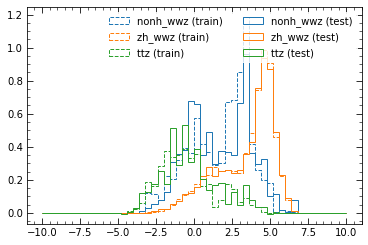

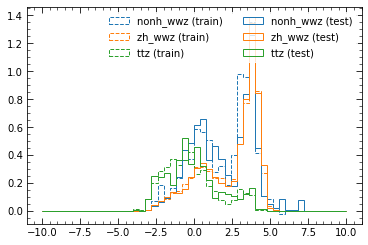

In [78]:
plot_bdt_scores(df.query("is_ChannelEMu"), "EMu_ttz_score_wwz", ["nonh_wwz", "zh_wwz", "ttz"])
plt.show()
plot_bdt_scores(df.query("is_ChannelEMu"), "EMu_ttz_score_nonh_wwz", ["nonh_wwz", "zh_wwz", "ttz"])
plt.show()

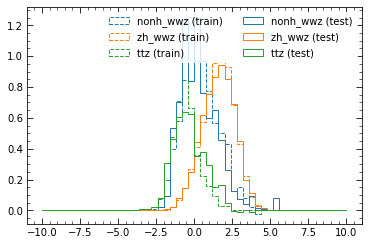

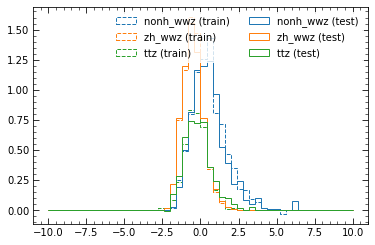

In [73]:
plot_bdt_scores(df.query("is_ChannelEMu"), "EMu_ttz_score_wwz", ["nonh_wwz", "zh_wwz", "ttz"])
plt.show()
plot_bdt_scores(df.query("is_ChannelEMu"), "EMu_ttz_score_nonh_wwz", ["nonh_wwz", "zh_wwz", "ttz"])
plt.show()